# Cis Effects Template

## Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

## Stuff to fill out

In [4]:
cancer_types = {
    # Put here all the types of cancer that you want to look at. 
    'ovarian': cptac.Ovarian(),
    'brca': cptac.Brca(),
    'gbm': cptac.Gbm(),
}

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\ipykernel_launcher.py, line 5)


In [5]:
# Enter the Chromosome and arm you are looking at. 
CHROMOSOME = '8'
ARM = 'p'
START = 0
END = 64255695

## Load all the data

In [6]:
proteomics = dict()
cnv = dict()
transcriptomics = dict()
for cancer_type in cancer_types:
    proteomics[cancer_type] = cancer_types[cancer_type].get_proteomics()
    cnv[cancer_type] = cancer_types[cancer_type].get_CNV()
    transcriptomics[cancer_type] = cancer_types[cancer_type].get_transcriptomics()

In [7]:
locations = get_gene_locations()

In [8]:
# Get just the genes that are in our event
subset_event = locations[(locations.chromosome == CHROMOSOME) & (locations.arm == ARM) & (locations.start_bp > START) & (locations.end_bp < END)]
genes = set(subset_event.index.get_level_values('Name'))

## Run Pearson Tests

In [9]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [10]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [11]:
proteomics_results

,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics,brca_pvalue_proteomics,brca_rvalue_proteomics,gbm_pvalue_proteomics,gbm_rvalue_proteomics
Name,,,,,,
ADAM28,7.649923e-01,0.096571,NaN,NaN,0.843886,0.082376
ADAM9,3.148689e-03,0.353400,3.286002e-04,0.338698,0.603964,0.098785
ADAMDEC1,8.912219e-01,0.034902,6.493226e-01,0.055638,NaN,NaN
ADGRA2,NaN,NaN,NaN,NaN,NaN,NaN
AGPAT5,9.319496e-07,0.554238,5.658353e-07,0.457864,0.711903,0.072493
...,...,...,...,...,...,...
ZDHHC2,NaN,NaN,NaN,NaN,0.858520,0.049884
ZMAT4,NaN,NaN,NaN,NaN,0.885174,-0.025350
ZNF395,NaN,NaN,NaN,NaN,0.898035,-0.024747


### Transcriptomics

In [12]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\c

In [13]:
transcriptomics_results

,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,gbm_pvalue_transcriptomics,gbm_rvalue_transcriptomics
Name,,,,,,
AC012119.1,NaN,NaN,NaN,NaN,NaN,NaN
AC021613.1,NaN,NaN,NaN,NaN,NaN,NaN
AC022616.1,NaN,NaN,NaN,NaN,NaN,NaN
AC022616.2,NaN,NaN,NaN,NaN,NaN,NaN
AC023385.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ZNF596,9.987394e-10,0.581995,1.767802e-08,0.502505,0.102702,0.214798
ZNF703,1.895350e-01,0.151221,9.166329e-05,0.366090,0.070534,0.233761
ZNF705B,4.966831e-01,0.077920,5.459853e-01,0.271453,0.907067,0.029318


## Create Graphs

In [14]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

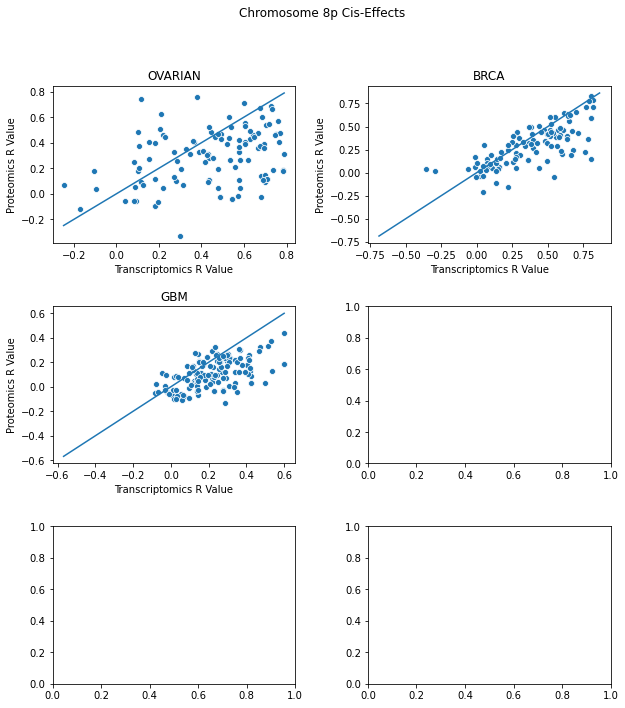

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("Transcriptomics R Value")
    axs[count//2][count%2].set_ylabel("Proteomics R Value")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)